# Convolutional Neural Networks

## What is a convolution?

- Let's consider a 2-D convolution (used, for example, in image processing): 
\begin{equation}
g(x,y)*f(x,y) = \sum_{s=-a}^a \sum_{t=-b}^b g(s,t)f(x-s,y-t)
\end{equation}
where $g$ is the filter and $f$ is the image to be convolved.  Essentially, we flip f both horizontally and vertically and, then, slide $g$ across $f$ where at each location we perform a pointwise multiplication and then a sum.  

- Why the flip?  Without flipping, the operation is a correlation (or also called cross-correlation).  
The equation for cross-correlation is: 
\begin{equation}
g(x,y)*f(x,y) = \sum_{s=-a}^a \sum_{t=-b}^b g(s,t)f(x+s,y+t)
\end{equation}

- A nice video describing the difference between convolution and cross-correlation can be found here: https://www.youtube.com/watch?v=C3EEy8adxvc

- A nice property of convolution is that it corresponds to the product in the frequency domain.  (Cross-correlation in the frequency domain is the product of $g$ and the complex conjugate of $f$. 

- Also, convolution is associative whereas correlation is not.  See the following example: 

In [1]:
import numpy as np

conv1 = np.convolve(np.convolve([-1,0,1], [-1, 0, 1], 'full'),  [1, 2, 3, 4, 5], 'full')
print(conv1)

conv2 = np.convolve([-1, 0, 1], np.convolve([-1,0,1], [1, 2, 3, 4, 5], 'full'), 'full')
print(conv2)


corr1 = np.correlate(np.correlate([-1,0,1], [-1, 0, 1], 'full'),  [1, 2, 3, 4, 5], 'full')
print(corr1)

corr2 = np.correlate([-1, 0, 1], np.correlate([-1,0,1], [1, 2, 3, 4, 5], 'full'), 'full')
print(corr2)



[ 1  2  1  0  0 -6 -7  4  5]
[ 1  2  1  0  0 -6 -7  4  5]
[-5 -4  7  6  0  0 -1 -2 -1]
[-1 -2 -1  0  0  6  7 -4 -5]


## Why would you use a convolution? 

- Convolutions are very common operations. Here are some image processing examples: 
    
- Edge Detection: Can detect edges by convolving with edge masks (e.g., the Sobel edge detectors): 
\begin{equation} \left[
\begin{array}[c c]\\
 -1 &0 & 1\\ -2 &0 &2\\ -1 &0 &1
\end{array} \right] \end{equation}

\begin{equation} \left[
\begin{array}[c c]\\
-1 &-2 & -1\\ 0 &0 & 0\\ 1 & 2 &1
\end{array} \right] \end{equation}

The vertical and horizontal Sobel edge masks are shown above. 

- Image Smoothing: Can smooth/blur images using a mean filter

- Unsharp Masking: Can sharpen imagery by subtracting a mean filtered image from the original

- and more... 


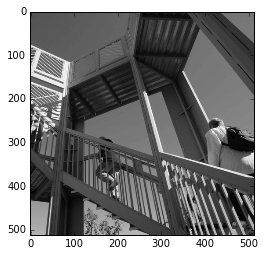

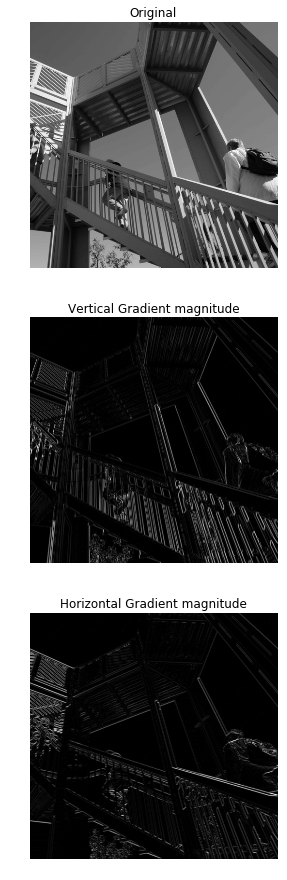

In [13]:
#Import Necessary Libraries
import scipy.signal as signal
import matplotlib.pyplot as plt
%matplotlib inline

# Create Sobel Edge Masks
vMask = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
hMask = np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]])

# Convolve Edge Masks with Image
gradV = signal.convolve2d(ascent, vMask, boundary='symm', mode='same')
gradH = signal.convolve2d(ascent, hMask, boundary='symm', mode='same')

# Visualize Results
fig, (ax_orig, ax_mag, ax_mag2) = plt.subplots(3, 1, figsize=(6, 15))
ax_orig.imshow(ascent, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_mag.imshow(abs(gradV), cmap='gray')
ax_mag.set_title('Vertical Gradient magnitude')
ax_mag.set_axis_off()
ax_mag2.imshow(abs(gradH), cmap='gray')
ax_mag2.set_title('Horizontal Gradient magnitude')
ax_mag2.set_axis_off()
plt.show()


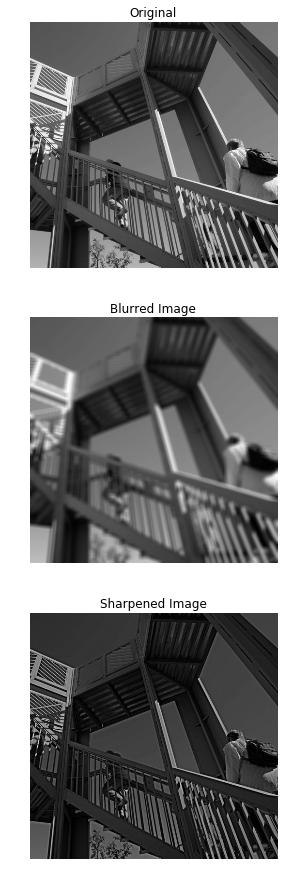

In [28]:
# Create Mean Filter
mMask = (1/100)*np.ones((10,10))


# Convolve Mean Masks with Image
blurI = signal.convolve2d(ascent, mMask, boundary='symm', mode='same')

# Perform unsharp masking
sharpI = ascent + (ascent - blurI)

# Visualize Results
fig, (ax_orig, ax_mag, ax_mag2) = plt.subplots(3, 1, figsize=(6, 15))
ax_orig.imshow(ascent, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_mag.imshow(abs(blurI), cmap='gray')
ax_mag.set_title('Blurred Image')
ax_mag.set_axis_off()
ax_mag2.imshow(abs(sharpI), cmap='gray')
ax_mag2.set_title('Sharpened Image')
ax_mag2.set_axis_off()
plt.show()

- So, various convolutions have the ability to enhance and extract features of interest. 
- The idea behind a convolutional neural network is to learn the features needed to perform classification (or regression) during the learning process for the neural network.  This is in contrast with approaches in which you first identify features of importance, extract them in advance, and then train a classifier (e.g., a neural network) on the extracted features

- CNNs are a form of shared weight neural networks.  This is because several weighted connections in the network are tied together to have the same value.

- To see this, first consider that a convolution can be written as a linear operation with a doubly block circulant matrix, 

\begin{equation}
H(x,y) = F(x,y)*g(x,y)
\end{equation}

is the same as

\begin{equation}
\mathbf{h} = \mathbf{G}\mathbf{f}
\end{equation}

where $\mathbf{f}$ and $\mathbf{h}$ are the vectorized forms of $F$ and $H$ and $\mathbf{G}$ is a doubly block circulant matrix.  

- Consider the following small image: 

\begin{equation}\mathbf{Im} = \left[
\begin{array}[c c c c]\\
1 & 2 & 3 & 4 \\
5 & 6 & 7 & 8 \\
9 & 10 & 11 & 12 \\
13 & 14 & 15 & 16 \\
\end{array} \right] \end{equation}

- We can vectorize it: 

\begin{equation}
\mathbf{I}^T = [1, 2, 3, 4, \ldots, 14, 15, 16]
\end{equation}

- Lets consider the following kernel: 

\begin{equation}\mathbf{k} = \left[
\begin{array}[c c c ]\\
-1 & -2 & -3  \\
-4 & -5 & -6 \\
-7 & -8 & -9 \\
\end{array} \right] \end{equation}

- Let K be: 

\begin{equation}\mathbf{K} = \left[
\begin{array}[c c c c c c c c c c c c c c c c ]\\
-1 & -2 & -3 & 0 & -4 & -5 & -6 & 0 & -7 & -8 & -9 & 0 & 0 & 0 & 0 & 0 \\
0 & -1 & -2 & -3 & 0 & -4 & -5 & -6 & 0 & -7 & -8 & -9 & 0 & 0 & 0 & 0  \\
0 & 0  & 0 & 0 & -1 & -2 & -3 & 0 & -4 & -5 & -6 & 0 & -7 & -8 & -9 & 0 \\
0 & 0  & 0 & 0 & 0 & -1 & -2 & -3 & 0 & -4 & -5 & -6 & 0 & -7 & -8 & -9 \\
\end{array} \right] \end{equation}

- So, we can write the convolution as

\begin{equation}
\mathbf{K}\mathbf{I}
\end{equation}